# Étude du Graphe DGraphFin - Détection de Fraude

## Introduction et Contexte

Ce notebook présente une étude complète du dataset **DGraphFin**, un graphe à grande échelle issu d'une plateforme fintech. L'objectif principal est de détecter les utilisateurs frauduleux en analysant la structure du réseau de transactions.

### Description du Dataset
- **Nœuds** : ~3.7M utilisateurs (17 features par nœud)
- **Arêtes** : ~4.3M relations de différents types (11 types d'arêtes)
- **Classes** :
  - **Classe 0** : Utilisateurs normaux (à prédire)
  - **Classe 1** : Utilisateurs frauduleux (à prédire)
  - **Classe 2 & 3** : Utilisateurs de fond (background)
- **Données temporelles** : Timestamps sur les arêtes

### Méthodologie
1. **Chargement et exploration** du graphe complet
2. **Analyse structurelle** (métriques de base, distribution des degrés)
3. **Extraction d'un sous-graphe** représentatif pour les analyses coûteuses
4. **Mesures de centralité** (PageRank, Degree, Eigenvector, Closeness, Betweenness)
5. **Embedding et clustering** (Spectral Embedding, Node2Vec)
6. **Comparaison et conclusions**

*Références* : [DGraphFin Paper](https://arxiv.org/abs/2207.08208)

In [16]:
# Installation des dépendances (décommenter si nécessaire)
# !uv pip install torch_geometric networkx matplotlib seaborn scikit-learn pandas --system

In [17]:
# Imports principaux
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, subgraph, degree, to_networkx, to_undirected

## 1. Chargement et Inspection des Données

Nous chargeons le fichier `dgraphfin.npz` qui contient :
- **x** : Features des nœuds (17 dimensions)
- **y** : Labels des nœuds (4 classes)
- **edge_index** : Indices des arêtes
- **edge_type** : Type de chaque arête (11 types)
- **edge_timestamp** : Timestamp de chaque arête
- **train/valid/test_mask** : Masques pour l'apprentissage supervisé

In [18]:
import os

# Chemin vers le fichier brut
data_path = os.path.join('data', 'DGraphFin', 'dgraphfin.npz')

if os.path.exists(data_path):
    print(f"Chargement de {data_path}...")
    with np.load(data_path) as loader:
        print("Clés disponibles :", loader.files)
        
        # Extraction des tableaux
        x = loader['x']
        y = loader['y']
        edge_index = loader['edge_index']
        edge_type = loader['edge_type']
        edge_timestamp = loader['edge_timestamp']
        train_mask = loader['train_mask']
        valid_mask = loader['valid_mask']
        test_mask = loader['test_mask']
        
        print(f"\n--- Dimensions des données ---")
        print(f"Nœuds (x) : {x.shape} → {x.shape[0]:,} nœuds avec {x.shape[1]} features")
        print(f"Arêtes (edge_index) : {edge_index.shape} → {edge_index.shape[0]:,} arêtes")
        print(f"Labels (y) : {y.shape}")
        print(f"Types d'arêtes uniques : {len(np.unique(edge_type))}")
        
        # Vérification des valeurs manquantes
        print(f"\nValeurs manquantes dans x : {np.isnan(x).sum()}")
        
        # Distribution des classes
        print(f"\n--- Distribution des Classes ---")
        for cls in np.unique(y):
            count = np.sum(y == cls)
            pct = 100 * count / len(y)
            label = {0: "Normal", 1: "Fraude", 2: "Background", 3: "Background"}[cls]
            print(f"  Classe {cls} ({label}) : {count:,} nœuds ({pct:.2f}%)")
else:
    print(f"Fichier {data_path} non trouvé.")

Chargement de data\DGraphFin\dgraphfin.npz...
Clés disponibles : ['x', 'y', 'edge_index', 'edge_type', 'edge_timestamp', 'train_mask', 'valid_mask', 'test_mask']

--- Dimensions des données ---
Nœuds (x) : (3700550, 17) → 3,700,550 nœuds avec 17 features
Arêtes (edge_index) : (4300999, 2) → 4,300,999 arêtes
Labels (y) : (3700550,)
Types d'arêtes uniques : 11

Valeurs manquantes dans x : 0

--- Distribution des Classes ---
  Classe 0 (Normal) : 1,210,092 nœuds (32.70%)
  Classe 1 (Fraude) : 15,509 nœuds (0.42%)
  Classe 2 (Background) : 1,620,851 nœuds (43.80%)
  Classe 3 (Background) : 854,098 nœuds (23.08%)


## Exemple

In [19]:
# Afficher les noms des features et leurs valeurs pour l'exemple 0
# Note: La documentation DGraphFin ne précise pas la signification de chaque feature
# pour des raisons de confidentialité (données bancaires désensibilisées)
exemple_idx = 0

print(f"Features pour le nœud {exemple_idx} (Classe: {y[exemple_idx]}):")
print("-" * 60)
for i, valeur in enumerate(x[exemple_idx]):
    print(f"Feature {i:2d}: {valeur:10.4f}")

Features pour le nœud 0 (Classe: 2):
------------------------------------------------------------
Feature  0:     0.0000
Feature  1:     5.0000
Feature  2:    -1.0000
Feature  3:    -1.0000
Feature  4:    -1.0000
Feature  5:    -1.0000
Feature  6:    -1.0000
Feature  7:    -1.0000
Feature  8:    -1.0000
Feature  9:    -1.0000
Feature 10:     0.0000
Feature 11:    -1.0000
Feature 12:    -1.0000
Feature 13:    -1.0000
Feature 14:    -1.0000
Feature 15:    -1.0000
Feature 16:    -1.0000


## 2. Création de l'Objet Graphe PyTorch Geometric

Nous convertissons les données NumPy en tenseurs PyTorch et créons un objet `Data` de PyG.

**Justification** : PyTorch Geometric est le framework de référence pour le Graph ML. Il permet d'exploiter efficacement les opérations sur graphes (convolutions, sampling, etc.) et offre de nombreux algorithmes pré-implémentés.

In [20]:
# Préparation des tenseurs PyTorch
x_t = torch.tensor(x, dtype=torch.float)
y_t = torch.tensor(y, dtype=torch.long)
edge_index_t = torch.tensor(edge_index, dtype=torch.long)

# PyG attend le format (2, E) pour edge_index. Si (E, 2), on transpose.
if edge_index_t.shape[0] != 2 and edge_index_t.shape[1] == 2:
    edge_index_t = edge_index_t.t().contiguous()

edge_timestamp_t = torch.tensor(edge_timestamp, dtype=torch.long)
edge_type_t = torch.tensor(edge_type, dtype=torch.long)

# Création de l'objet Data PyG
data = Data(
    x=x_t, 
    edge_index=edge_index_t, 
    y=y_t, 
    edge_attr=edge_timestamp_t,  # Timestamps comme attributs d'arêtes
    edge_type=edge_type_t
)

print("=== Objet Graphe PyG ===")
print(data)
print(f"\n--- Propriétés Structurelles ---")
print(f"Nombre de nœuds : {data.num_nodes:,}")
print(f"Nombre d'arêtes : {data.num_edges:,}")
print(f"Degré moyen : {data.num_edges / data.num_nodes:.2f}")
print(f"Nœuds isolés : {data.has_isolated_nodes()}")
print(f"Graphe dirigé : {data.is_directed()}")

=== Objet Graphe PyG ===
Data(x=[3700550, 17], edge_index=[2, 4300999], edge_attr=[4300999], y=[3700550], edge_type=[4300999])

--- Propriétés Structurelles ---
Nombre de nœuds : 3,700,550
Nombre d'arêtes : 4,300,999
Degré moyen : 1.16
Nœuds isolés : False
Graphe dirigé : True


## 3. Analyse Basique du Graphe Complet

Avant d'extraire un sous-graphe, nous effectuons une analyse préliminaire sur l'ensemble du graphe pour comprendre sa structure globale.

**Métriques calculées** :
- Distribution des degrés (entrée, sortie, total)
- Répartition des types d'arêtes
- Distribution temporelle des arêtes

=== Statistiques des Degrés (Graphe Complet) ===
Degré sortant - min: 0, max: 6, moy: 1.16
Degré entrant - min: 0, max: 882, moy: 1.16
Degré total   - min: 1, max: 882, moy: 2.32


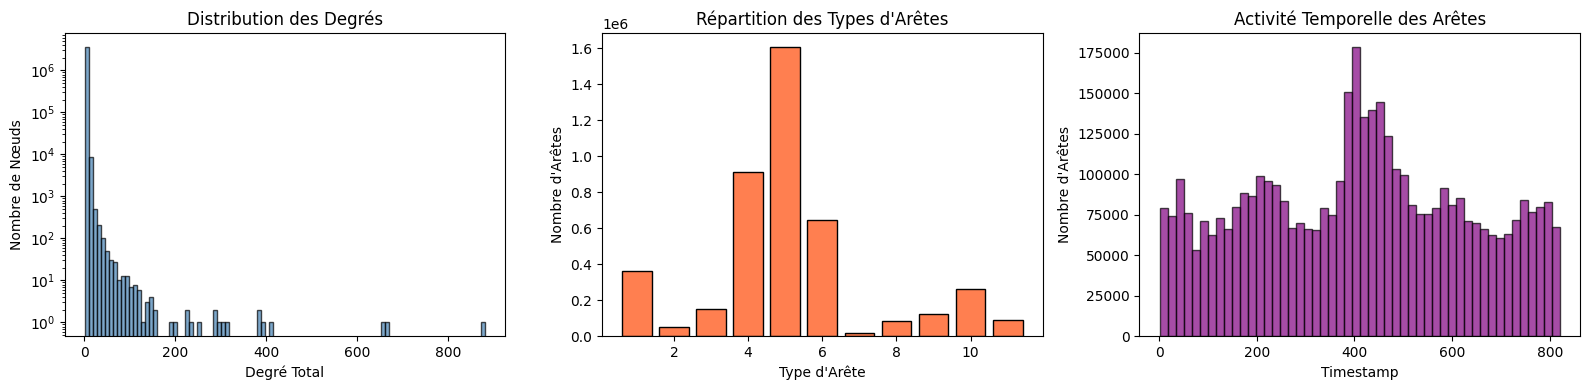


=== Degré Moyen par Classe ===
  Classe 0 (Normal) : degré moyen = 2.89
  Classe 1 (Fraude) : degré moyen = 1.95
  Classe 2 (Background) : degré moyen = 1.97
  Classe 3 (Background) : degré moyen = 2.20


In [21]:
# Analyse du graphe complet (sans NetworkX pour éviter les problèmes de mémoire)

# 1. Distribution des degrés (sur le graphe complet avec PyG)
deg_out = degree(data.edge_index[0], num_nodes=data.num_nodes)  # Degré sortant
deg_in = degree(data.edge_index[1], num_nodes=data.num_nodes)   # Degré entrant
deg_total = deg_out + deg_in

print("=== Statistiques des Degrés (Graphe Complet) ===")
print(f"Degré sortant - min: {int(deg_out.min())}, max: {int(deg_out.max())}, moy: {deg_out.mean():.2f}")
print(f"Degré entrant - min: {int(deg_in.min())}, max: {int(deg_in.max())}, moy: {deg_in.mean():.2f}")
print(f"Degré total   - min: {int(deg_total.min())}, max: {int(deg_total.max())}, moy: {deg_total.mean():.2f}")

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Distribution des degrés (log-log pour voir la loi de puissance)
axes[0].hist(deg_total.numpy(), bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel("Degré Total")
axes[0].set_ylabel("Nombre de Nœuds")
axes[0].set_title("Distribution des Degrés")
axes[0].set_yscale('log')

# Distribution des types d'arêtes
edge_types_unique, edge_types_counts = np.unique(edge_type, return_counts=True)
axes[1].bar(edge_types_unique, edge_types_counts, color='coral', edgecolor='black')
axes[1].set_xlabel("Type d'Arête")
axes[1].set_ylabel("Nombre d'Arêtes")
axes[1].set_title("Répartition des Types d'Arêtes")

# Distribution temporelle
axes[2].hist(edge_timestamp, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[2].set_xlabel("Timestamp")
axes[2].set_ylabel("Nombre d'Arêtes")
axes[2].set_title("Activité Temporelle des Arêtes")

plt.tight_layout()
plt.show()

# 2. Analyse par classe
print("\n=== Degré Moyen par Classe ===")
for cls in np.unique(y):
    mask = (y_t == cls)
    avg_deg = deg_total[mask].mean().item()
    label = {0: "Normal", 1: "Fraude", 2: "Background", 3: "Background"}[cls]
    print(f"  Classe {cls} ({label}) : degré moyen = {avg_deg:.2f}")

## 4. Extraction d'un Sous-Graphe Représentatif

### Justification
Le graphe complet (~3.7M nœuds, ~4.3M arêtes) est trop volumineux pour certaines analyses coûteuses en complexité :
- **Centralité** : $O(n^2)$ à $O(n^3)$ selon la métrique
- **Embedding Spectral** : $O(n^3)$ pour la décomposition en valeurs propres

### Stratégie d'Échantillonnage
Nous utilisons l'extraction **k-hop subgraph** autour d'un nœud hub :
1. Conversion en graphe non-dirigé pour capturer les voisins entrants ET sortants
2. Sélection d'un nœud "hub" (top degré) comme centre
3. Extraction du voisinage à k-hop (k=1 ou k=2 selon la taille)
4. Limitation à ~1000 nœuds pour la tractabilité

Cette approche préserve la structure locale tout en capturant un échantillon représentatif du réseau autour d'un nœud potentiellement intéressant (hub = point de passage de nombreuses transactions).

Nœud central choisi (Top Degree) : 646108
Degré du nœud central : 882

=== Sous-graphe Extrait ===
Nombre de nœuds : 997
Rayon (k-hop) : 2
Nombre d'arêtes : 1768
Densité : 0.0018
Degré max (dans le sous-graphe) : 882
Coefficient de clustering moyen : 0.0059


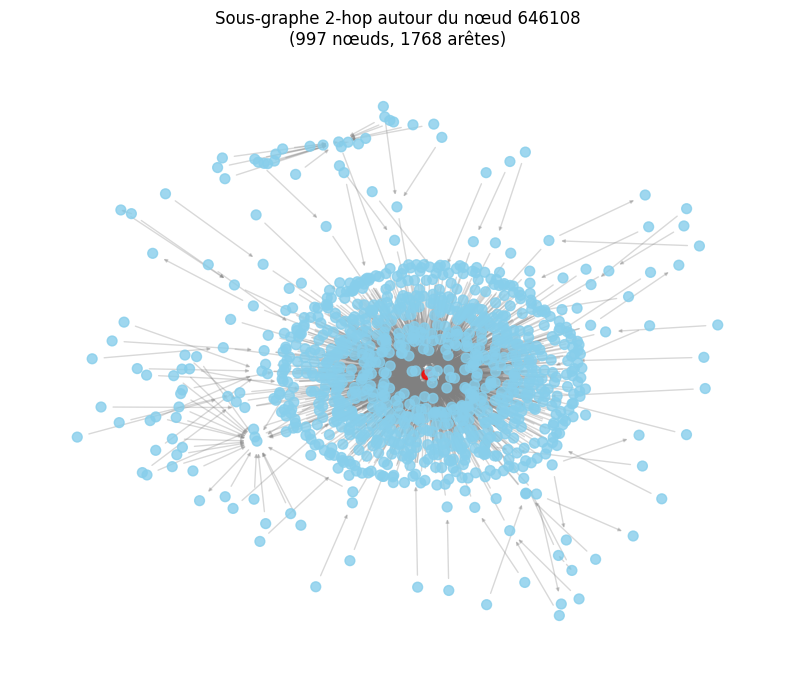

In [22]:
# =============================================================================
# 4. EXTRACTION D'UN SOUS-GRAPHE REPRÉSENTATIF
# =============================================================================
# Justification : Le graphe complet est trop volumineux pour les analyses
# coûteuses (centralité O(n²), embedding spectral O(n³)).
# Stratégie : Extraction d'un sous-graphe k-hop autour d'un nœud hub.
# =============================================================================

# 1. Conversion en graphe non-dirigé pour capturer tous les voisins
edge_index_undirected = to_undirected(data.edge_index)

# Calcul des degrés sur le graphe non-dirigé
deg = degree(edge_index_undirected[0], num_nodes=data.num_nodes)

# 2. Sélection du nœud central (top degré)
topk_values, topk_indices = torch.topk(deg, 20)
center_node_idx = topk_indices[0].item()
print(f"Nœud central choisi (Top Degree) : {center_node_idx}")
print(f"Degré du nœud central : {int(deg[center_node_idx].item())}")

# 3. Extraction du voisinage k-hop
num_hops = 2
subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx=center_node_idx, 
    num_hops=num_hops, 
    edge_index=edge_index_undirected,
    relabel_nodes=True
)

# Contrôle de la taille (limite ~1000 nœuds pour tractabilité)
if subset.size(0) > 1000:
    print(f"Sous-graphe 2-hop trop grand ({subset.size(0)} nœuds). Réduction à 1-hop.")
    num_hops = 1
    subset, sub_edge_index, mapping, _ = k_hop_subgraph(
        node_idx=center_node_idx, 
        num_hops=1, 
        edge_index=edge_index_undirected, 
        relabel_nodes=True
    )

print(f"\n=== Sous-graphe Extrait ===")
print(f"Nombre de nœuds : {subset.size(0)}")
print(f"Rayon (k-hop) : {num_hops}")

# 4. Extraction des arêtes ORIGINALES (dirigées) pour l'analyse
original_sub_edge_index, _ = subgraph(subset, data.edge_index, relabel_nodes=True)

# 5. Création de l'objet Data pour le sous-graphe
sub_data = Data(x=data.x[subset], edge_index=original_sub_edge_index, y=data.y[subset])

# 6. Conversion en NetworkX pour les analyses classiques
G_sub = to_networkx(sub_data, to_undirected=False)  # Graphe dirigé
G_sub_undir = G_sub.to_undirected()                  # Version non-dirigée

# 7. Métriques de base du sous-graphe
nb_nodes = G_sub.number_of_nodes()
nb_edges = G_sub.number_of_edges()
density = nb_edges / (nb_nodes * (nb_nodes - 1)) if nb_nodes > 1 else 0
avg_clustering_coeff = nx.average_clustering(G_sub_undir)
degrees = [d for n, d in G_sub.degree()]
max_degree_sub = max(degrees) if degrees else 0

print(f"Nombre d'arêtes : {nb_edges}")
print(f"Densité : {density:.4f}")
print(f"Degré max (dans le sous-graphe) : {max_degree_sub}")
print(f"Coefficient de clustering moyen : {avg_clustering_coeff:.4f}")

# 8. Visualisation du sous-graphe
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sub, seed=42, k=0.15)

# Couleur : Rouge pour le centre, Bleu pour les autres
center_sub_idx = list(subset.numpy()).index(center_node_idx)
node_colors = ['red' if i == center_sub_idx else 'skyblue' for i in range(nb_nodes)]

nx.draw_networkx_nodes(G_sub, pos, node_size=50, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G_sub, pos, edge_color="gray", alpha=0.3, arrows=True, arrowsize=5)
plt.title(f"Sous-graphe {num_hops}-hop autour du nœud {center_node_idx}\n({nb_nodes} nœuds, {nb_edges} arêtes)")
plt.axis('off')
plt.show()

## 5. Analyse Approfondie du Sous-Graphe

Maintenant que nous avons extrait un sous-graphe représentatif, nous analysons :
- **Répartition des classes** : Le voisinage est-il homogène ou mixte ?
- **Distribution des degrés** : Structure "star" (1 hub) ou communauté dense ?
- **Activité temporelle** : Y a-t-il des patterns temporels dans les transactions ?

C:\Users\chris\AppData\Local\Temp\ipykernel_50616\1165879664.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_classes, y=counts_classes, ax=axes[0, 0], palette="Set2")


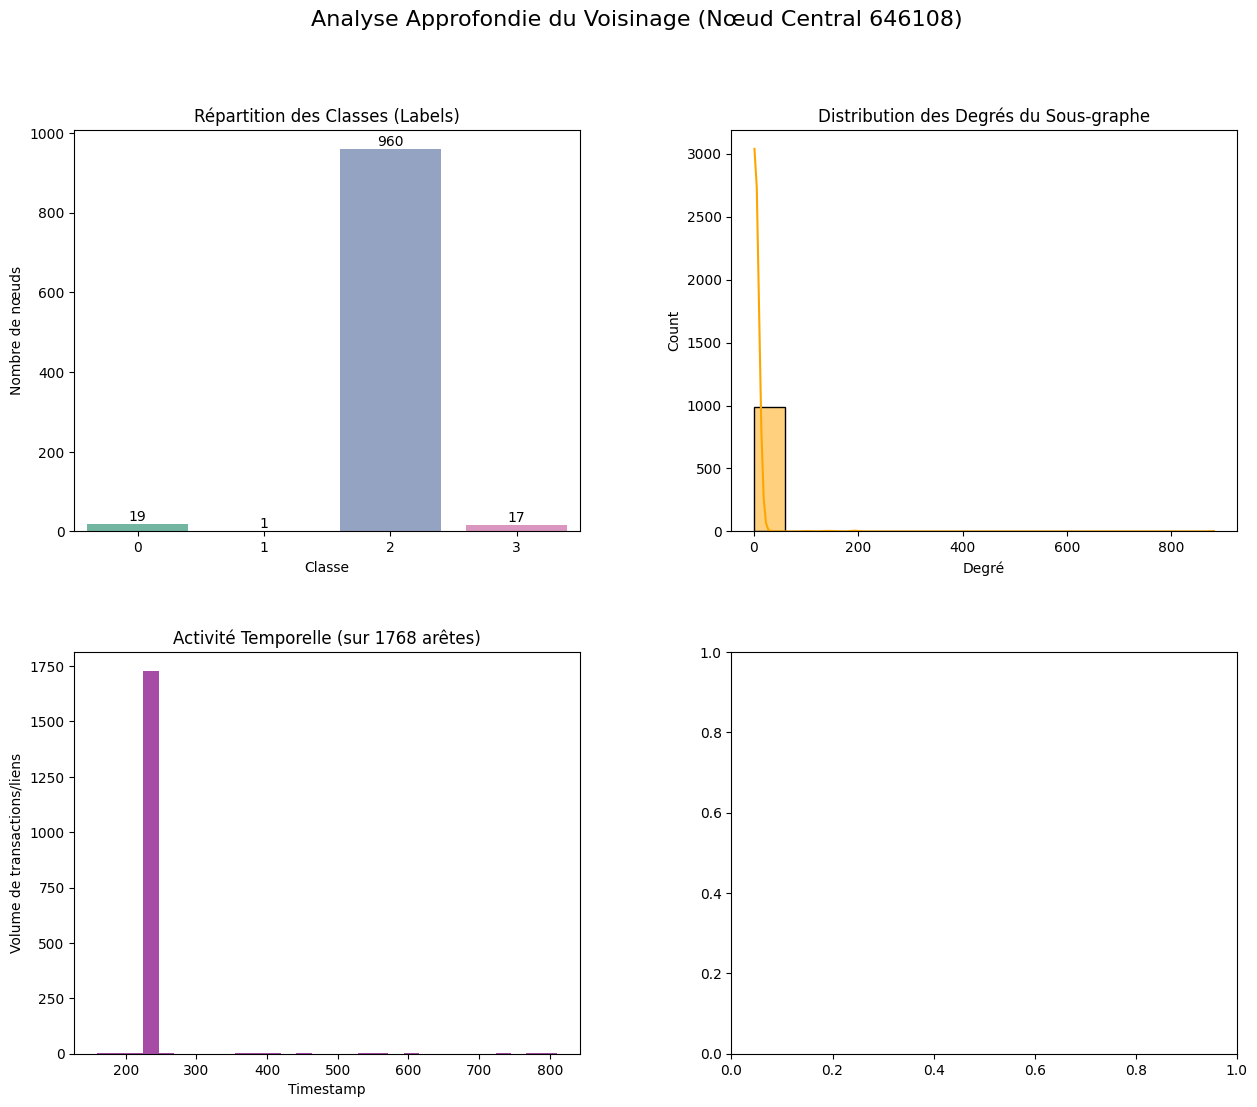

In [23]:
import seaborn as sns
from torch_geometric.utils import subgraph

# A. Récupération des données spécifiques au sous-graphe
# On réutilise 'subset' pour extraire les timestamps et les labels correspondants
sub_edge_index, sub_edge_attr = subgraph(subset, data.edge_index, edge_attr=data.edge_attr, relabel_nodes=True)
sub_labels = data.y[subset].numpy()
sub_timestamps = sub_edge_attr.numpy()
sub_degrees = [d for n, d in G_sub.degree()]

# B. Visualisation composite
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. Répartition des Classes
# Permet de voir l'homogénéité du voisinage (ex: tout fraude ou mixte ?)
unique_classes, counts_classes = np.unique(sub_labels, return_counts=True)
sns.barplot(x=unique_classes, y=counts_classes, ax=axes[0, 0], palette="Set2")
axes[0, 0].set_title("Répartition des Classes (Labels)")
axes[0, 0].set_xlabel("Classe")
axes[0, 0].set_ylabel("Nombre de nœuds")
for i, count in enumerate(counts_classes):
    axes[0, 0].text(i, count, str(count), ha='center', va='bottom')

# 2. Distribution des Degrés
# Permet de valider la structure locale (Star graph vs Dense community)
sns.histplot(sub_degrees, bins=15, kde=True, ax=axes[0, 1], color="orange")
axes[0, 1].set_title("Distribution des Degrés du Sous-graphe")
axes[0, 1].set_xlabel("Degré")

# 3. Activité Temporelle
# Analyse de la dynamique temporelle des arêtes
axes[1, 0].hist(sub_timestamps, bins=30, color="purple", alpha=0.7)
axes[1, 0].set_title(f"Activité Temporelle (sur {len(sub_timestamps)} arêtes)")
axes[1, 0].set_xlabel("Timestamp")
axes[1, 0].set_ylabel("Volume de transactions/liens")


plt.suptitle(f"Analyse Approfondie du Voisinage (Nœud Central {center_node_idx})", fontsize=16)
plt.show()

## 6. Spectral Embedding et Clustering

### Justification du Spectral Embedding
Le **Spectral Embedding** est une technique de réduction de dimension basée sur la décomposition spectrale du Laplacien du graphe. Elle projette les nœuds dans un espace où les nœuds connectés sont proches.

**Pourquoi cette méthode ?**
- Capture la structure globale du graphe (pas seulement locale)
- Fondée sur des bases théoriques solides (théorie spectrale des graphes)
- Les k plus petits vecteurs propres révèlent les partitions naturelles du graphe
- Idéale pour le clustering de communautés

**Paramètres** :
- `n_components=16` : Dimension de l'embedding (compromis information/complexité)
- `affinity='precomputed'` : Utilisation directe de la matrice d'adjacence
- Clustering K-Means avec k=4 (correspondant aux 4 classes)

Exécution du Spectral Embedding...
Alignement avec les étiquettes réelles (ARI) : 0.0286


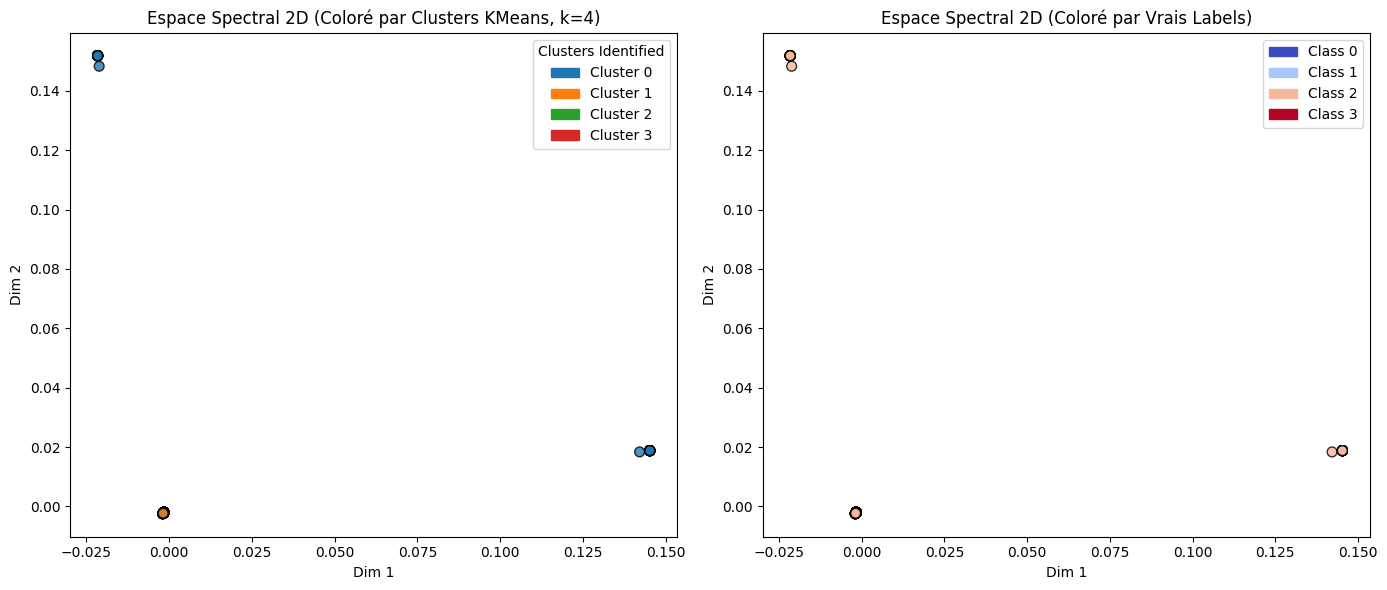

C:\Users\chris\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


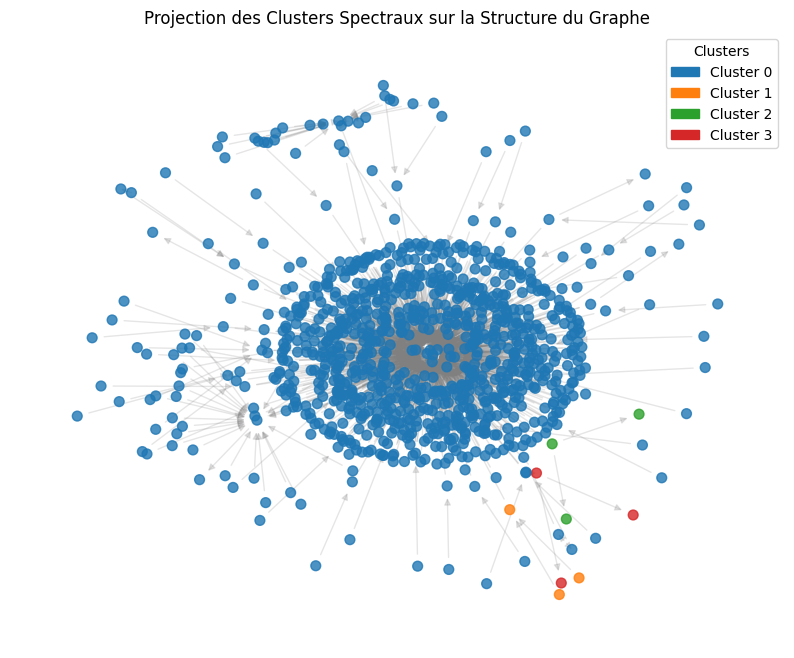

In [24]:
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.patches as mpatches

# ==========================================
# 4. Spectral Embedding & Clustering (Sur le sous-graphe)
# ==========================================

print("Exécution du Spectral Embedding...")

# 1. Utilisation de la matrice d'adjacence du sous-graphe
# On travaille sur la version non-dirigée pour le Spectral Clustering classique
adj_mat = nx.to_numpy_array(G_sub_undir)

# 2. Spectral Embedding
# Projection des nœuds dans un espace de dimension reduite (ex: 16)
embedding_dim = 16
spectral = SpectralEmbedding(n_components=embedding_dim, affinity='precomputed', random_state=42)
# Note: SpectralEmbedding attend une matrice d'affinité (adjacence ici)
X_embedded = spectral.fit_transform(adj_mat)

# 3. Clustering (K-Means) dans l'espace spectral
# On cherche k clusters. Une bonne heuristique est le nombre de classes réelles + quelques variations structurelles
n_clusters = 4 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_embedded)

# 4. Évaluation (Comparaison avec les vrais labels - si pertinent)
# ARI (Adjusted Rand Index) mesure la similarité entre le clustering et les vrais labels
# ARI proche de 0 = aléatoire, 1 = parfait accord
ari_score = adjusted_rand_score(sub_labels, cluster_labels)
print(f"Alignement avec les étiquettes réelles (ARI) : {ari_score:.4f}")

# 5. Visualisation (Projection 2D de l'embedding pour voir les clusters)
# On ré-effectue un embedding en 2D juste pour le plot, ou on PCA les 16 dims.
# Faisons simple : Spectral Embedding 2D direct pour la viz
spectral_2d = SpectralEmbedding(n_components=2, affinity='precomputed', random_state=42)
X_2d = spectral_2d.fit_transform(adj_mat)

plt.figure(figsize=(14, 6))

# Plot A: Espace Embedding (Coloré par Cluster trouvé)
plt.subplot(1, 2, 1)
# Utilisation de 'tab10' qui offre des couleurs catégorielles bien distinctes
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='tab10', s=50, alpha=0.8, edgecolor='k', vmin=0, vmax=9)
plt.title(f"Espace Spectral 2D (Coloré par Clusters KMeans, k={n_clusters})")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")

# Légende Discrète pour les Clusters
patches_clusters = [mpatches.Patch(color=plt.cm.tab10(i), label=f'Cluster {i}') for i in range(n_clusters)]
plt.legend(handles=patches_clusters, title="Clusters Identified")

# Plot B: Espace Embedding (Coloré par Vrais Labels)
plt.subplot(1, 2, 2)
# On s'assure que les labels sont binaires ou discrets pour la couleur
scatter_real = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=sub_labels, cmap='coolwarm', s=50, alpha=0.8, edgecolor='k')
plt.title("Espace Spectral 2D (Coloré par Vrais Labels)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")

# Légende manuelle pour les vrais labels
colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_classes)))
patches = [mpatches.Patch(color=colors[i], label=f'Class {cls}') for i, cls in enumerate(unique_classes)]
plt.legend(handles=patches)

plt.tight_layout()
plt.show()

# 6. Visualisation sur le Graphe (La structure physique)
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G_sub, pos, node_size=50, node_color=cluster_labels, cmap='tab10', alpha=0.8, vmin=0, vmax=9)
nx.draw_networkx_edges(G_sub, pos, edge_color="gray", alpha=0.2)
plt.title("Projection des Clusters Spectraux sur la Structure du Graphe")
plt.axis('off')
plt.legend(handles=patches_clusters, title="Clusters")
plt.show()

## 7. Shallow Embedding avec Node2Vec

### Justification de Node2Vec
**Node2Vec** est une méthode de "shallow embedding" basée sur des random walks. Elle apprend des représentations de nœuds en optimisant la prédiction du contexte (voisinage) de chaque nœud.

**Pourquoi Node2Vec ?**
- Plus flexible que le Spectral Embedding grâce aux paramètres p et q
- Capture à la fois l'**homophilie** (p, q ~ 1) et l'**équivalence structurelle**
- Scalable aux grands graphes grâce au sampling par random walks
- Comparaison intéressante avec le Spectral Embedding

**Paramètres** :
- `embedding_dim=64` : Dimension des embeddings
- `walk_length=20`, `walks_per_node=10` : Longueur et nombre de random walks
- `p=1, q=1` : BFS-like exploration (favorise l'homophilie locale)
- Visualisation via t-SNE pour projection en 2D

Entraînement de Node2Vec...
Epoch: 10, Loss: 24.8779
Epoch: 20, Loss: 36.9671
Epoch: 30, Loss: 45.6165
Projection t-SNE des embeddings Node2Vec...


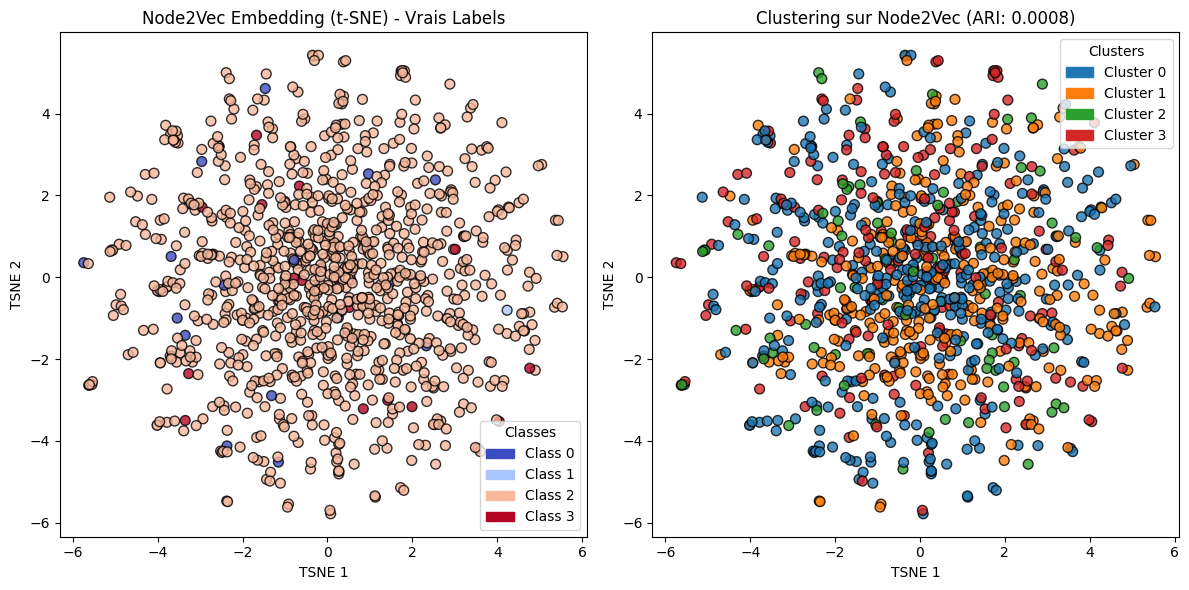

Comparaison ARI:
Spectral Clustering: 0.0286
Node2Vec: 0.0008


In [25]:
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE

# Préparation des arêtes pour Node2Vec (PyG Node2Vec prend edge_index)
sub_edge_index_mapped, _ = subgraph(subset, data.edge_index, relabel_nodes=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Configuration du modèle Node2Vec
model = Node2Vec(sub_edge_index_mapped, embedding_dim=64, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader_n2v = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

# Entraînement
print("Entraînement de Node2Vec...")
model.train()
total_loss = 0
for epoch in range(1, 31): # 30 époques
    for pos_rw, neg_rw in loader_n2v:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {total_loss / len(loader_n2v):.4f}')

# Extraction des embeddings
model.eval()
z = model().detach().cpu().numpy()

# Visualisation avec t-SNE
print("Projection t-SNE des embeddings Node2Vec...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, z.shape[0]-1))
z_tsne = tsne.fit_transform(z)

# Plot
plt.figure(figsize=(12, 6))

# Plot A: Node2Vec Embeddings (Coloré par Vrais Labels)
plt.subplot(1, 2, 1)
scatter_n2v = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=sub_labels, cmap='coolwarm', s=50, alpha=0.8, edgecolor='k')
plt.title("Node2Vec Embedding (t-SNE) - Vrais Labels")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(handles=patches, title="Classes")

# Plot B: Clustering sur Node2Vec
# On applique KMeans sur les embeddings Node2Vec (64 dims)
kmeans_n2v = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters_n2v = kmeans_n2v.fit_predict(z)
ari_n2v = adjusted_rand_score(sub_labels, clusters_n2v)

plt.subplot(1, 2, 2)
scatter_cluster_n2v = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=clusters_n2v, cmap='tab10', s=50, alpha=0.8, edgecolor='k', vmin=0, vmax=9)
plt.title(f"Clustering sur Node2Vec (ARI: {ari_n2v:.4f})")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.legend(handles=[mpatches.Patch(color=plt.cm.tab10(i), label=f'Cluster {i}') for i in range(n_clusters)], title="Clusters")

plt.tight_layout()
plt.show()

print(f"Comparaison ARI:\nSpectral Clustering: {ari_score:.4f}\nNode2Vec: {ari_n2v:.4f}")

## 8. Mesures de Centralité

### Comparaison des Métriques de Centralité

Les métriques de centralité permettent d'identifier les nœuds "importants" selon différents critères :

| Métrique | Description | Interprétation |
|----------|-------------|----------------|
| **Degree Centrality** | Proportion de voisins directs | Nœuds "populaires" localement |
| **Eigenvector Centrality** | Importance pondérée par l'importance des voisins | Nœuds connectés à d'autres nœuds importants |
| **Betweenness Centrality** | Fréquence de passage sur les plus courts chemins | Nœuds "ponts" entre communautés |
| **Closeness Centrality** | Proximité moyenne à tous les autres nœuds | Nœuds centraux dans le réseau |

### Degree vs Eigenvector Centrality
- **Degree** : Mesure simple du nombre de connexions
- **Eigenvector** : Raffine le degree en considérant la qualité des connexions
- Un nœud peut avoir un faible degree mais un fort eigenvector s'il est connecté à des hubs

=== Calcul des Métriques de Centralité ===

--- Corrélation entre Degree et Eigenvector Centrality ---
Corrélation de Pearson : 0.9441
→ Une forte corrélation suggère une structure homogène.
→ Une faible corrélation indique des nœuds à faible degree mais bien connectés.

--- Centralité Moyenne par Classe ---
       Degree_Centrality  Betweenness_Centrality  Closeness_Centrality  \
Label                                                                    
0                 0.0113                  0.0011                0.3323   
1                 0.0010                  0.0000                0.3219   
2                 0.0035                  0.0013                0.4610   
3                 0.0012                  0.0000                0.3841   

       Eigenvector_Centrality  
Label                          
0                      0.0102  
1                      0.0007  
2                      0.0227  
3                      0.0089  


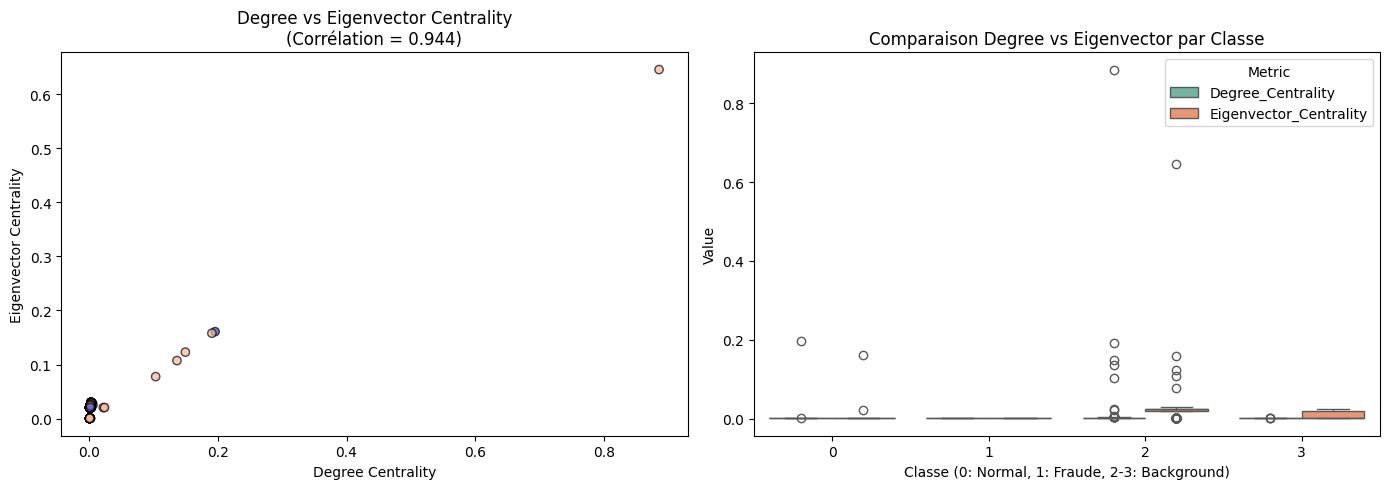


--- Corrélation des Métriques avec le Label (Fraude) ---
Degree_Centrality        -0.0362
Betweenness_Centrality   -0.0017
Closeness_Centrality      0.2412
Eigenvector_Centrality    0.0366
Name: Label, dtype: float64


In [26]:
# Calcul des métriques de centralité sur le sous-graphe non-dirigé
print("=== Calcul des Métriques de Centralité ===\n")

centrality_degree = nx.degree_centrality(G_sub_undir)
centrality_betweenness = nx.betweenness_centrality(G_sub_undir)
centrality_closeness = nx.closeness_centrality(G_sub_undir)
centrality_eigenvector = nx.eigenvector_centrality(G_sub_undir, max_iter=1000)

# Création d'un DataFrame pour l'analyse
df_metrics = pd.DataFrame({
    'Node_Index': range(nb_nodes),
    'Label': sub_labels,
    'Cluster_Spectral': cluster_labels,
    'Cluster_Node2Vec': clusters_n2v,
    'Degree_Centrality': [centrality_degree[i] for i in range(nb_nodes)],
    'Betweenness_Centrality': [centrality_betweenness[i] for i in range(nb_nodes)],
    'Closeness_Centrality': [centrality_closeness[i] for i in range(nb_nodes)],
    'Eigenvector_Centrality': [centrality_eigenvector[i] for i in range(nb_nodes)]
})

# Comparaison Degree vs Eigenvector Centrality
print("--- Corrélation entre Degree et Eigenvector Centrality ---")
corr_deg_eig = df_metrics['Degree_Centrality'].corr(df_metrics['Eigenvector_Centrality'])
print(f"Corrélation de Pearson : {corr_deg_eig:.4f}")
print("→ Une forte corrélation suggère une structure homogène.")
print("→ Une faible corrélation indique des nœuds à faible degree mais bien connectés.\n")

# Comparaison des métriques par Classe
print("--- Centralité Moyenne par Classe ---")
print(df_metrics.groupby('Label')[['Degree_Centrality', 'Betweenness_Centrality', 
                                    'Closeness_Centrality', 'Eigenvector_Centrality']].mean().round(4))

# Visualisation : Degree vs Eigenvector
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot Degree vs Eigenvector
axes[0].scatter(df_metrics['Degree_Centrality'], df_metrics['Eigenvector_Centrality'], 
                c=sub_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
axes[0].set_xlabel("Degree Centrality")
axes[0].set_ylabel("Eigenvector Centrality")
axes[0].set_title(f"Degree vs Eigenvector Centrality\n(Corrélation = {corr_deg_eig:.3f})")

# Boxplots par classe
metrics_to_plot = ['Degree_Centrality', 'Eigenvector_Centrality']
df_melted = df_metrics.melt(id_vars=['Label'], value_vars=metrics_to_plot, 
                            var_name='Metric', value_name='Value')
sns.boxplot(x='Label', y='Value', hue='Metric', data=df_melted, ax=axes[1], palette='Set2')
axes[1].set_xlabel("Classe (0: Normal, 1: Fraude, 2-3: Background)")
axes[1].set_title("Comparaison Degree vs Eigenvector par Classe")

plt.tight_layout()
plt.show()

# Corrélation globale avec la Fraude
print("\n--- Corrélation des Métriques avec le Label (Fraude) ---")
correlation = df_metrics[['Label', 'Degree_Centrality', 'Betweenness_Centrality', 
                          'Closeness_Centrality', 'Eigenvector_Centrality']].corr()['Label']
print(correlation.drop('Label').round(4))

## 9. PageRank : Mesure d'Influence

### Justification de PageRank
**PageRank** (initialement développé pour Google) mesure l'importance d'un nœud en tenant compte de :
- Le nombre de liens entrants (comme Degree)
- La qualité des sources (nœuds pointant vers lui)

**Formule** : $PR(v) = \frac{1-d}{N} + d \sum_{u \in B_v} \frac{PR(u)}{L(u)}$

Où $d$ est le facteur de damping (0.85), $B_v$ les nœuds pointant vers $v$, et $L(u)$ le nombre de liens sortants de $u$.

**Avantages sur Degree Centrality** :
- Robuste au spam (beaucoup de liens de mauvaise qualité)
- Capture la propagation d'influence dans le réseau
- Particulièrement pertinent pour la détection de fraude (influence des réseaux de mules)

=== PageRank et Analyse d'Influence ===

--- Top 10 Nœuds Influents (PageRank) ---
     Node_Index  Label  PageRank  Degree_Centrality  Cluster_Spectral
12           12      2  0.275615           0.885542                 0
38           38      0  0.039037           0.195783                 0
233         233      2  0.038065           0.190763                 0
222         222      2  0.028283           0.149598                 0
263         263      2  0.027127           0.136546                 0
11           11      2  0.020293           0.103414                 0
303         303      2  0.010325           0.024096                 0
287         287      2  0.009879           0.022088                 0
278         278      2  0.004917           0.001004                 0
715         715      2  0.002306           0.006024                 0

Corrélation PageRank vs Degree : 0.9906

--- PageRank Moyen par Classe ---
           mean       std       max
Label                              

C:\Users\chris\AppData\Local\Temp\ipykernel_50616\367922018.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y='PageRank', data=df_metrics, palette='Set2', ax=axes[0])


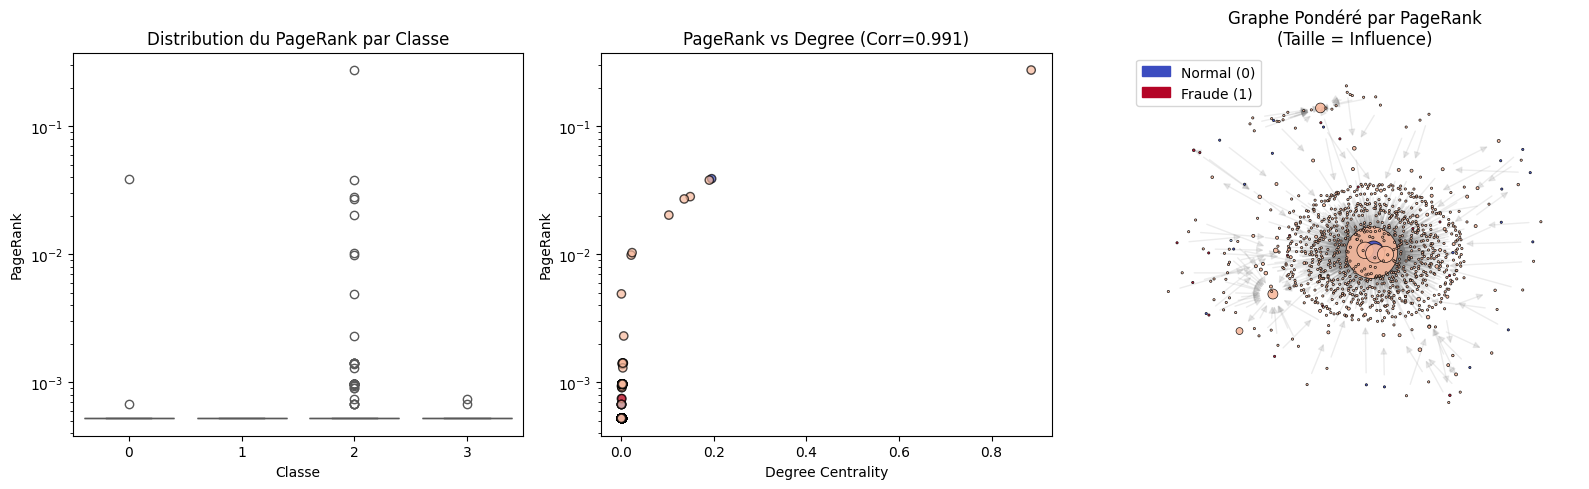

In [27]:
from sklearn.metrics import silhouette_score

print("=== PageRank et Analyse d'Influence ===\n")

# 1. Calcul du PageRank (sur graphe dirigé pour capter le flux réel)
pagerank = nx.pagerank(G_sub, alpha=0.85)
df_metrics['PageRank'] = [pagerank[i] for i in range(nb_nodes)]

# 2. Top 10 des nœuds les plus influents
top_influencers = df_metrics.nlargest(10, 'PageRank')
print("--- Top 10 Nœuds Influents (PageRank) ---")
print(top_influencers[['Node_Index', 'Label', 'PageRank', 'Degree_Centrality', 'Cluster_Spectral']])

# 3. Comparaison PageRank vs Degree
corr_pr_deg = df_metrics['PageRank'].corr(df_metrics['Degree_Centrality'])
print(f"\nCorrélation PageRank vs Degree : {corr_pr_deg:.4f}")

# 4. Distribution du PageRank par Classe
print("\n--- PageRank Moyen par Classe ---")
print(df_metrics.groupby('Label')['PageRank'].agg(['mean', 'std', 'max']).round(6))

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# A. Distribution du PageRank par Classe (boxplot)
sns.boxplot(x='Label', y='PageRank', data=df_metrics, palette='Set2', ax=axes[0])
axes[0].set_xlabel("Classe")
axes[0].set_ylabel("PageRank")
axes[0].set_title("Distribution du PageRank par Classe")
axes[0].set_yscale('log')  # Échelle log car distribution très asymétrique

# B. PageRank vs Degree Scatter
axes[1].scatter(df_metrics['Degree_Centrality'], df_metrics['PageRank'], 
                c=sub_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
axes[1].set_xlabel("Degree Centrality")
axes[1].set_ylabel("PageRank")
axes[1].set_title(f"PageRank vs Degree (Corr={corr_pr_deg:.3f})")
axes[1].set_yscale('log')

# C. Graphe avec taille proportionnelle au PageRank
import matplotlib.patches as mpatches
node_sizes = [v * 5000 for v in pagerank.values()]
nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, node_color=sub_labels, 
                       cmap='coolwarm', alpha=0.9, linewidths=0.5, edgecolors='k', ax=axes[2])
nx.draw_networkx_edges(G_sub, pos, edge_color="gray", alpha=0.15, ax=axes[2])
axes[2].set_title("Graphe Pondéré par PageRank\n(Taille = Influence)")
axes[2].axis('off')
legend_elements = [
    mpatches.Patch(color=plt.cm.coolwarm(0.0), label='Normal (0)'),
    mpatches.Patch(color=plt.cm.coolwarm(1.0), label='Fraude (1)')
]
axes[2].legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

## 10. Coefficient de Clustering

### Définition
Le **coefficient de clustering local** d'un nœud $i$ mesure la densité de connexions entre ses voisins :

$$C_i = \frac{2 \times |\{e_{jk} : v_j, v_k \in N_i, e_{jk} \in E\}|}{k_i(k_i - 1)}$$

Où $k_i$ est le degré du nœud et $N_i$ son voisinage.

### Interprétation dans le Contexte de la Fraude
- **Cliques** ($C \approx 1$) : Réseaux de mules coordonnés, groupes frauduleux
- **Structure Star** ($C \approx 0$) : Fraudeur isolé connectant des utilisateurs légitimes
- **Corrélation avec Degree** : Les hubs ont généralement un clustering plus faible

=== Analyse du Coefficient de Clustering ===

Coefficient de Clustering Moyen (Global) : 0.0059

--- Clustering Coefficient par Classe ---
         mean     std  median
Label                        
0      0.0526  0.2294     0.0
1      0.0000     NaN     0.0
2      0.0030  0.0483     0.0
3      0.1176  0.3321     0.0

--- Corrélation du Clustering avec les autres Métriques ---
Degree_Centrality        -0.0037
PageRank                 -0.0019
Eigenvector_Centrality   -0.0535
Label                     0.0058
Name: Clustering_Coeff, dtype: float64


C:\Users\chris\AppData\Local\Temp\ipykernel_50616\2305729641.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y='Clustering_Coeff', data=df_metrics, palette='Set2', ax=axes[1])


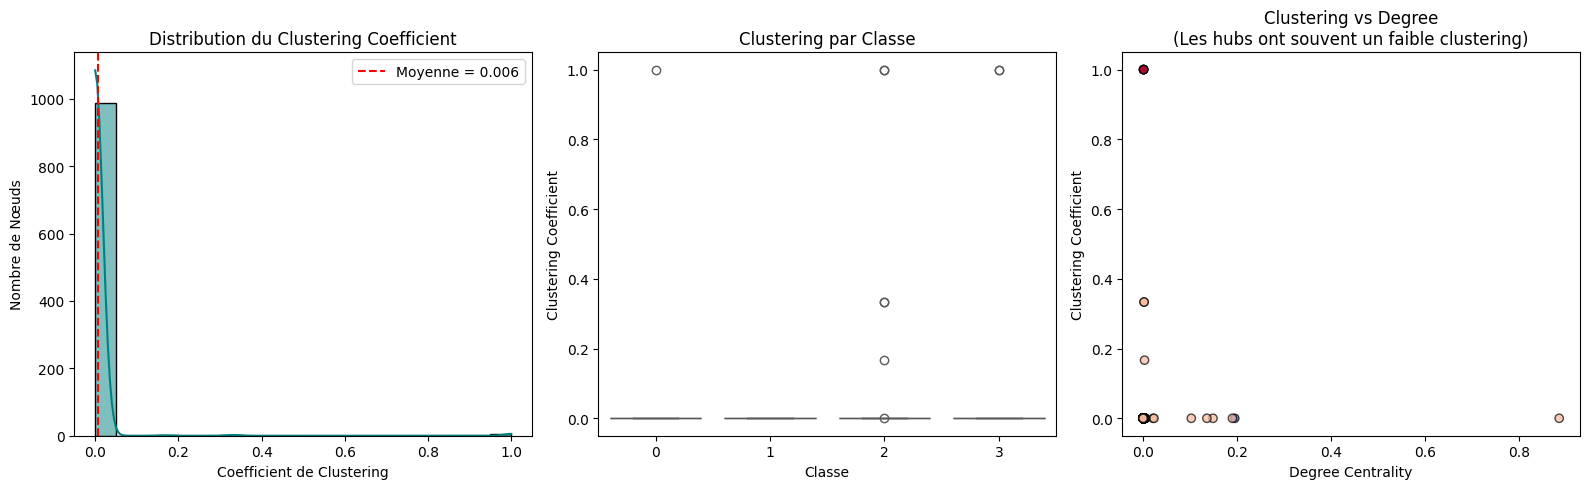


--- Interprétation ---
→ Le sous-graphe a un faible clustering, suggérant une structure plus 'star-like' ou 'arbre'.


In [28]:
# Calcul du Coefficient de Clustering par nœud
print("=== Analyse du Coefficient de Clustering ===\n")

clustering_coeffs = nx.clustering(G_sub_undir)
df_metrics['Clustering_Coeff'] = [clustering_coeffs[i] for i in range(nb_nodes)]

# Statistiques globales
avg_clustering = nx.average_clustering(G_sub_undir)
print(f"Coefficient de Clustering Moyen (Global) : {avg_clustering:.4f}")

# Par classe
print("\n--- Clustering Coefficient par Classe ---")
print(df_metrics.groupby('Label')['Clustering_Coeff'].agg(['mean', 'std', 'median']).round(4))

# Corrélation avec les autres métriques
print("\n--- Corrélation du Clustering avec les autres Métriques ---")
correlations_clustering = df_metrics[['Clustering_Coeff', 'Degree_Centrality', 
                                       'PageRank', 'Eigenvector_Centrality', 'Label']].corr()['Clustering_Coeff']
print(correlations_clustering.drop('Clustering_Coeff').round(4))

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# A. Distribution du Clustering Coefficient
sns.histplot(df_metrics['Clustering_Coeff'], bins=20, kde=True, ax=axes[0], color='teal')
axes[0].axvline(avg_clustering, color='red', linestyle='--', label=f'Moyenne = {avg_clustering:.3f}')
axes[0].set_xlabel("Coefficient de Clustering")
axes[0].set_ylabel("Nombre de Nœuds")
axes[0].set_title("Distribution du Clustering Coefficient")
axes[0].legend()

# B. Boxplot par Classe
sns.boxplot(x='Label', y='Clustering_Coeff', data=df_metrics, palette='Set2', ax=axes[1])
axes[1].set_xlabel("Classe")
axes[1].set_ylabel("Clustering Coefficient")
axes[1].set_title("Clustering par Classe")

# C. Clustering vs Degree (trade-off classique dans les réseaux)
axes[2].scatter(df_metrics['Degree_Centrality'], df_metrics['Clustering_Coeff'], 
                c=sub_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
axes[2].set_xlabel("Degree Centrality")
axes[2].set_ylabel("Clustering Coefficient")
axes[2].set_title("Clustering vs Degree\n(Les hubs ont souvent un faible clustering)")

plt.tight_layout()
plt.show()

# Interprétation
print("\n--- Interprétation ---")
if avg_clustering < 0.3:
    print("→ Le sous-graphe a un faible clustering, suggérant une structure plus 'star-like' ou 'arbre'.")
else:
    print("→ Le sous-graphe montre un clustering significatif, indiquant des communautés locales denses.")

=== Comparaison Quantitative des Méthodes ===

--- Score de Silhouette (Qualité du Clustering) ---
  Spectral Embedding : 0.8898
  Node2Vec           : -0.0070
  → Plus proche de 1 = clusters mieux séparés

--- Adjusted Rand Index (Alignement avec Labels Réels) ---
  Spectral Embedding : 0.0286
  Node2Vec           : 0.0008
  → Plus proche de 1 = meilleur alignement avec la vérité terrain

--- Tableau Récapitulatif ---
           Méthode  Silhouette Score  ARI (Adjusted Rand Index)  Dimension Embedding
Spectral Embedding          0.889824                   0.028568                   16
          Node2Vec         -0.006968                   0.000763                   64


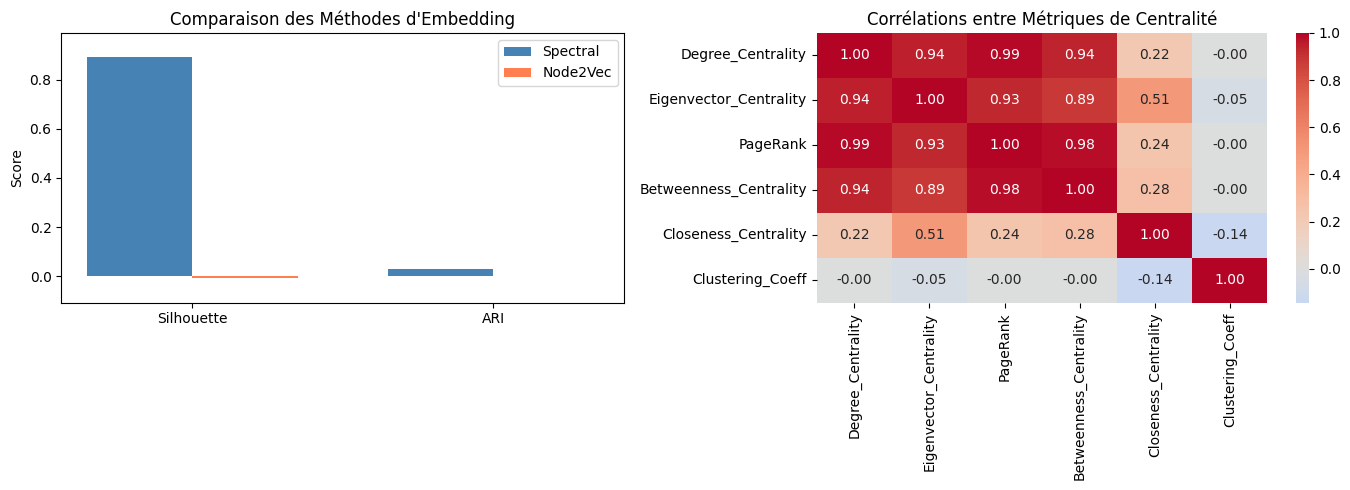

In [29]:
from sklearn.metrics import silhouette_score

print("=== Comparaison Quantitative des Méthodes ===\n")

# Scores de Silhouette (qualité intrinsèque du clustering)
sil_spectral = silhouette_score(X_embedded, cluster_labels)
sil_n2v = silhouette_score(z, clusters_n2v)

print("--- Score de Silhouette (Qualité du Clustering) ---")
print(f"  Spectral Embedding : {sil_spectral:.4f}")
print(f"  Node2Vec           : {sil_n2v:.4f}")
print("  → Plus proche de 1 = clusters mieux séparés\n")

# Adjusted Rand Index (alignement avec les vrais labels)
print("--- Adjusted Rand Index (Alignement avec Labels Réels) ---")
print(f"  Spectral Embedding : {ari_score:.4f}")
print(f"  Node2Vec           : {ari_n2v:.4f}")
print("  → Plus proche de 1 = meilleur alignement avec la vérité terrain\n")

# Tableau récapitulatif
comparison_df = pd.DataFrame({
    'Méthode': ['Spectral Embedding', 'Node2Vec'],
    'Silhouette Score': [sil_spectral, sil_n2v],
    'ARI (Adjusted Rand Index)': [ari_score, ari_n2v],
    'Dimension Embedding': [embedding_dim, 64]
})
print("--- Tableau Récapitulatif ---")
print(comparison_df.to_string(index=False))

# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Comparaison des scores
metrics = ['Silhouette', 'ARI']
spectral_scores = [sil_spectral, ari_score]
n2v_scores = [sil_n2v, ari_n2v]

x_pos = np.arange(len(metrics))
width = 0.35

axes[0].bar(x_pos - width/2, spectral_scores, width, label='Spectral', color='steelblue')
axes[0].bar(x_pos + width/2, n2v_scores, width, label='Node2Vec', color='coral')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparaison des Méthodes d\'Embedding')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim([min(0, min(spectral_scores + n2v_scores) - 0.1), 
                  max(spectral_scores + n2v_scores) + 0.1])

# Heatmap des corrélations entre métriques
corr_matrix = df_metrics[['Degree_Centrality', 'Eigenvector_Centrality', 
                          'PageRank', 'Betweenness_Centrality', 
                          'Closeness_Centrality', 'Clustering_Coeff']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1], fmt='.2f')
axes[1].set_title('Corrélations entre Métriques de Centralité')

plt.tight_layout()
plt.show()

# Notebook incomplet

Pour des contraintes de temps liés à mon camarade je vous transmet ce notebook sans la partie GNN puisqu'il travail dessus. Navré pour le désagrement